In [4]:
import sys
sys.path.append("..")

import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from pathlib import Path
from src.utils import search_for_data_files

In [ ]:
map_dirs = {
    "coughing_batch_2" : "cough",
    "coughing"         : "cough",
    "people_talking"   : "talking",
    "mic_tapping"      : "tapping",
    "laugh"            : "laughing"
}

base_dir_train = "../data/original_audio/train"
base_dir_test  = "../data/original_audio/test"
train_input_dirs  = [os.path.join(base_dir_train, dir)       
                     for dir in os.listdir(base_dir_train) if "DS_Store" not in dir] 
train_output_dirs = [f"../data/spectrograms/train/{map_dirs[dir]}" 
                     for dir in os.listdir(base_dir_train) if "DS_Store" not in dir]

test_input_dirs  = [os.path.join(base_dir_test, dir) 
                    for dir in os.listdir(base_dir_test) if "DS_Store" not in dir] 
test_output_dirs = [f"../data/spectrograms/test/{map_dirs[dir]}"  
                    for dir in os.listdir(base_dir_test) if "DS_Store" not in dir]


## 2. Explore cough statistics

In [9]:
input_dir = Path("../data/original_audio/train")

# finding recursively wave and label files
audio_files = search_for_data_files(input_dir, '*.wav')
label_files = search_for_data_files(input_dir, '*.label')

cough_audio = [filename for filename in audio_files if "coughing" in str(filename)]
laugh_audio = [filename for filename in audio_files if "laugh" in str(filename)]
talk_audio  = [filename for filename in audio_files if "talk" in str(filename)]
mic_audio   = [filename for filename in audio_files if "mic" in str(filename)]

cough_label = [filename for filename in label_files if "coughing" in str(filename)]
laugh_label = [filename for filename in label_files if "laugh" in str(filename)]
talk_label  = [filename for filename in label_files if "talk" in str(filename)]
mic_label   = [filename for filename in label_files if "mic" in str(filename)]

### 2.1 Check the lengths for the coughs

Roughly 97.5% of coughs have length less than 1.99sec
Coughs that last longer than 2 seconds correspond to 2.51% of total
[2.06049, 2.38104, 2.58294, 2.60754, 2.66588, 2.75469, 2.99877, 3.07346, 3.07757, 3.4520800000000005]


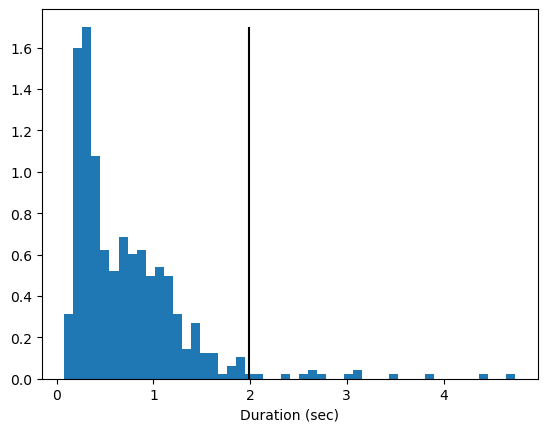

In [10]:
# List all cough lengths and derive statistics 
cough_lengths = []
for label_file in cough_label:
    df_label = pd.read_csv(str(label_file))
    cough_lengths.extend(df_label["Length(Seconds)"].tolist())

print(f"Roughly 97.5% of coughs have length less than {np.percentile(cough_lengths, 97.5):.2f}sec")
cough_arr  = np.round(np.array(cough_lengths)*100,3)/100
long_cough = cough_arr[np.where(cough_arr>2)[0]]
print(f"Coughs that last longer than 2 seconds correspond to {len(long_cough)/len(cough_arr)*100:.2f}% of total")
print([cough for cough in sorted(long_cough)[:10]])


l_hist =plt.hist(cough_lengths, 50, density=True)
plt.xlabel("Duration (sec)")
plt.vlines(np.percentile(cough_lengths, 97.5), ymin=0, ymax=max(l_hist[0]), colors= "black")
plt.savefig("../docs/figures/cough_histogram.png")

### 2.2 Check individual segments of the audio clip

In [12]:
import librosa
from IPython.display import Audio

In [13]:
audio_laugh = "../data/original_audio/train/laugh/folder_2/f0147_0_laughter.wav"
audio_cough = "../data/original_audio/train/coughing/184871__eelke__coughing/data.wav"
audio_tap   = "../data/original_audio/train/mic_tapping/studio/149034__susychristiansen__tappingmic/data.wav"
audio_talk  = "../data/original_audio/train/people_talking/groups-people-small-town-square-athens-greece/data.wav"

In [37]:
y, sr = librosa.load(audio_laugh, sr=None)
print(sr)
Audio(y, rate=sr)

16000


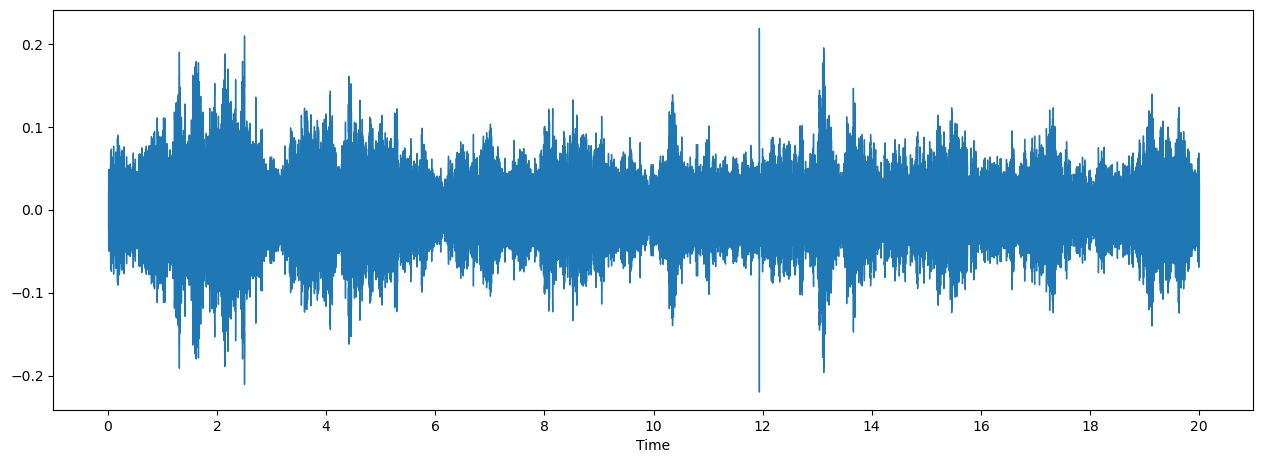

In [18]:
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1, 1, 1)
fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

y, sr = librosa.load(audio_talk, sr=None, duration=20)
librosa.display.waveshow(y, sr=sr, ax=ax)
ax.label_outer()
_ = ax.set_xticks(range(0, 21, 2)) 
_ = ax.set_xticklabels(range(0, 21, 2))
# fig.savefig("../docs/figures/audio_talk_chunk_20sec.png")



## 3. Visualize some data

In [21]:
import librosa
from librosa import display
from librosa.feature import melspectrogram
from librosa import power_to_db

In [22]:
audio_laugh = "../data/original_audio/train/laugh/folder_2/f0147_0_laughter.wav"
audio_cough = "../data/original_audio/train/coughing/184871__eelke__coughing/data.wav"
audio_tap   = "../data/original_audio/train/mic_tapping/studio/149034__susychristiansen__tappingmic/data.wav"
audio_talk  = "../data/original_audio/train/people_talking/groups-people-small-town-square-athens-greece/data.wav"

Text(0.5, 1.0, 'Mel frequency components in decibel')

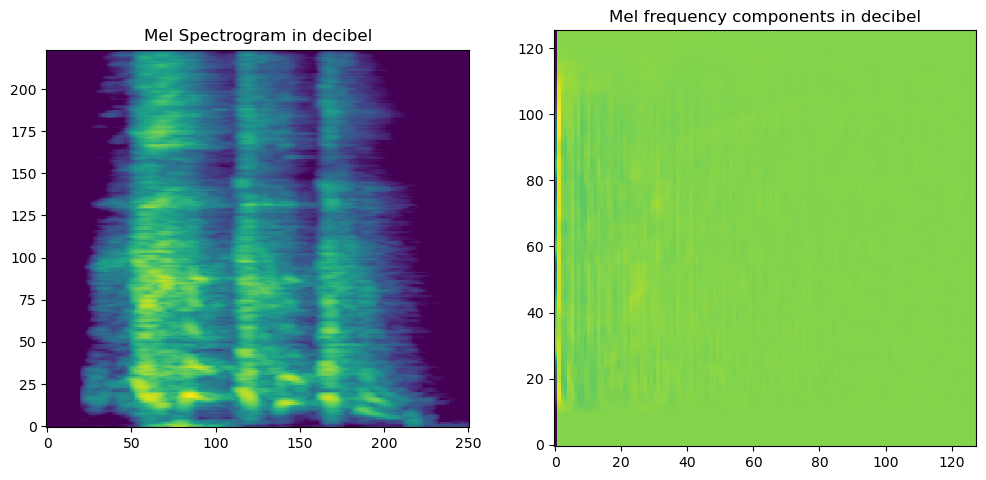

In [39]:
audio_file = audio_cough
y, sr = librosa.load(audio_file, sr=None)
x1 = int(3 * sr) 
x2 = int(5 * sr) 

fig, ax = plt.subplots(1, 2, figsize=(14,6))

ms = librosa.feature.melspectrogram(y=y[x1:x2], sr=sr, hop_length=128, n_fft=2048, n_mels=224)
log_ms = librosa.power_to_db(ms, ref=np.max)
# librosa.display.specshow(log_ms, sr=sr, ax=ax[0])
ax[0].imshow(log_ms, interpolation='nearest',  origin='lower')
ax[0].set_title("Mel Spectrogram in decibel")
# plt.savefig("../docs/figures/audio_cough_spectrogram.png")

mfcc = librosa.feature.mfcc(y=y[x1:x2], sr=sr, n_mfcc=128, hop_length=256)
mfcc_data= np.swapaxes(mfcc, 0, 1)
ax[1].imshow(mfcc_data, interpolation='nearest',  origin='lower')
# librosa.display.specshow(mfcc_data, sr=sr, ax=ax[1])
ax[1].set_title("Mel frequency components in decibel")

Text(0.5, 1.0, 'Mel frequency components in decibel')

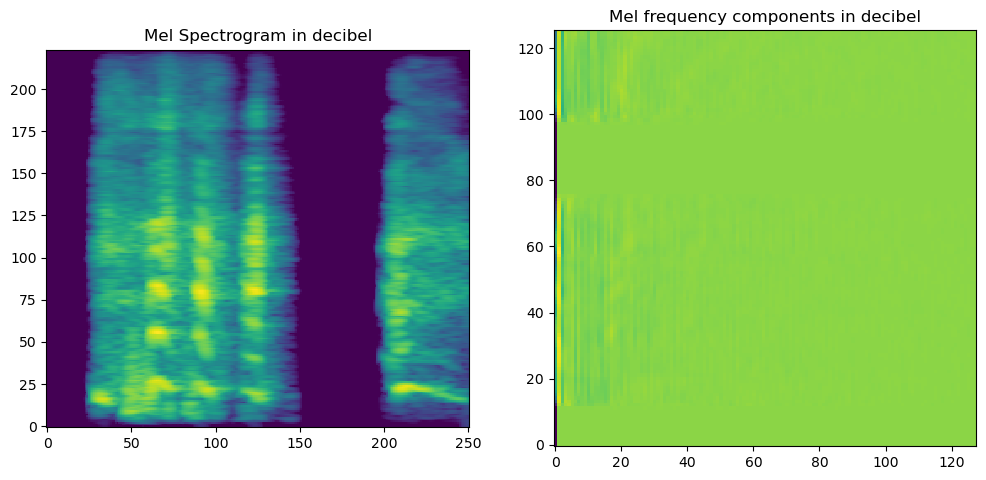

In [40]:
audio_file = audio_laugh
y, sr = librosa.load(audio_file, sr=16000)
x1 = int(0.5 * sr) 
x2 = int(2.5 * sr) 

fig, ax = plt.subplots(1, 2, figsize=(14,6))

ms = librosa.feature.melspectrogram(y=y[x1:x2], sr=sr, hop_length=128, n_fft=2048, n_mels=224)
log_ms = librosa.power_to_db(ms, ref=np.max)
# librosa.display.specshow(log_ms, sr=sr, ax=ax[0])
ax[0].imshow(log_ms, interpolation='nearest',  origin='lower')
ax[0].set_title("Mel Spectrogram in decibel")
# plt.savefig("../docs/figures/audio_cough_spectrogram.png")

mfcc = librosa.feature.mfcc(y=y[x1:x2], sr=sr, n_mfcc=128, hop_length=256)
mfcc_data= np.swapaxes(mfcc, 0, 1)
ax[1].imshow(mfcc_data, interpolation='nearest',  origin='lower')
# librosa.display.specshow(mfcc_data, sr=sr, ax=ax[1])
ax[1].set_title("Mel frequency components in decibel")

## Appendix 1

In this section, we verify the annonated segments for cough-related audio clips. We use the provided code to generate label vectors and compare their length with the duration of each cough segment (multiplied by the `sample rate sr`). The interested reader can verify that the relative difference between the generated vectors and the cough durations is of the order $10^{-4}$.

In [46]:

from scipy.io import wavfile
from src.label_parsing import wave_to_csv, convert_track_to_label

audio_list = cough_audio
label_list = cough_label
x1 = 0
x2 = None
diffs = []
for audio_file, label_file in zip(audio_list[x1:x2], label_list[x1:x2]):
    # loading data to csv
    data_df  = wave_to_csv(audio_file)
    label_df = pd.read_csv(label_file)
    y_vector = convert_track_to_label(data_df, label_df)
    
    sr, audio_signal = wavfile.read(audio_file)
    # print(f"Audio length {audio_signal.shape} || y_vector {y_vector.shape}") 

    n_ones = 0;
    for idx in label_df.index.values:
        start = label_df["Time(Seconds)"][idx]
        dur   = label_df["Length(Seconds)"][idx]
        # print(f"idx is {idx} || start {start:.2f} || {dur:.2f}")
        x1 = int( start * sr)
        x2 = int((start + dur) * sr)
        n_ones += y_vector[x1:x2].sum()
    
    diff = abs(n_ones-y_vector.sum()) / y_vector.sum() 
    diffs.append(diff)
    # if diff > 0.0001:
    #     print("------------------------------------------------------------------------")
    #     print("Data File:", audio_file)
    #     print("Label File:", label_file)   
    #     print(f"Expected {n_ones} || actual {y_vector.sum()} || relative diff is {diff*100:.6f}%")

print(f"Max relative difference is {max(diffs)*100:.4f}%")

Max relative difference is 0.0281%
